In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import factory as importer
import pandas as pd
import numpy as np
import BEP_PM

### Importing an event log from scratch:#

In [2]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/Road_Traffic_Fine_Management_Process.xes')
rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', log=log, resource_id='org:resource')
rf.save()

### Importing a previously loaded event log:#

In [3]:
rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', resource_id='org:resource')

### Manual reordering to match paper's segment order: ###

In [4]:
segments = rf.filter_segments()
segments[-1], segments[-2] = segments[-2], segments[-1] 
segments.insert(0, segments.pop(-1))
segments[-1], segments[-2] = segments[-2], segments[-1] 

### Creation of Performance Spectrum Data Frame using a duration classifier using histograms on 4 classes: ###

In [14]:
rf.first, rf.last

(datetime.datetime(2000, 1, 1, 1, 0), datetime.datetime(2013, 6, 18, 2, 0))

In [11]:
rf.performance_spectrum(segments, x_max=int(1500), metric='duration', classifier=rf.classify_duration_hist, args=[4])
rf.pf.head()

,resource,start_time,start_y,end_time,end_y,duration,segment_name,segment_index,case_id,start,end,class
0,9,490,120,500,100,10,"(Create Fine, Payment)",0,23766,"(490, 120)","(500, 100)",3.0
1,27,148,100,238,80,90,"(Create Fine, Send Fine)",1,23767,"(148, 100)","(238, 80)",3.0
2,27,238,80,257,60,19,"(Send Fine, Insert Fine Notification)",2,23767,"(238, 80)","(257, 60)",2.0
3,27,257,60,317,40,60,"(Insert Fine Notification, Add penalty)",3,23767,"(257, 60)","(317, 40)",3.0
4,27,317,40,340,20,23,"(Add penalty, Payment)",4,23767,"(317, 40)","(340, 20)",1.0


### Plotting the Performance Spectrum using the same 4 colors as in the paper, adding a mask on the Performance Spectrum Data frame to limit te maximum end time:###

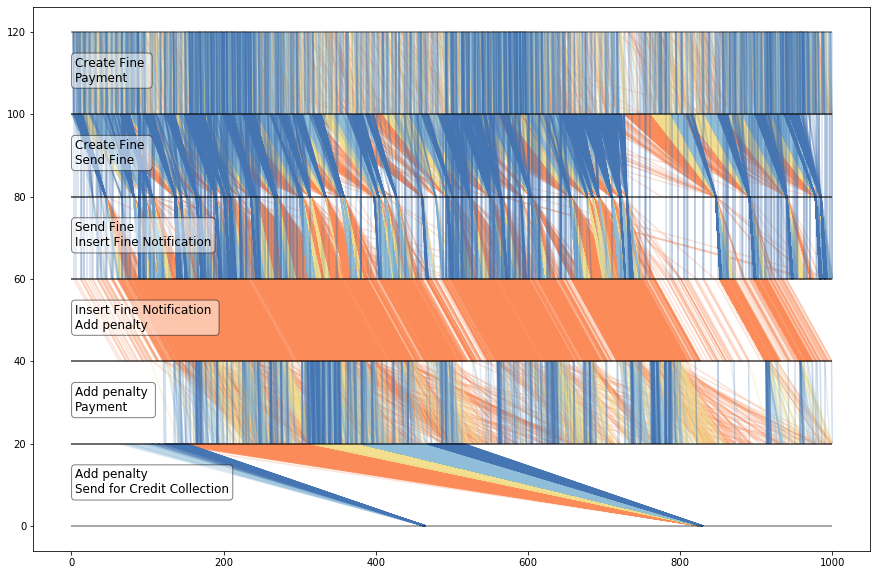

In [12]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=(rf.pf['end_time'] <= 1000))

### Plotting the Performance Spectrum using the same 4 colors as in the paper, adding a mask on the Performance Spectrum Data frame to only show segments processed by a specific resource:###

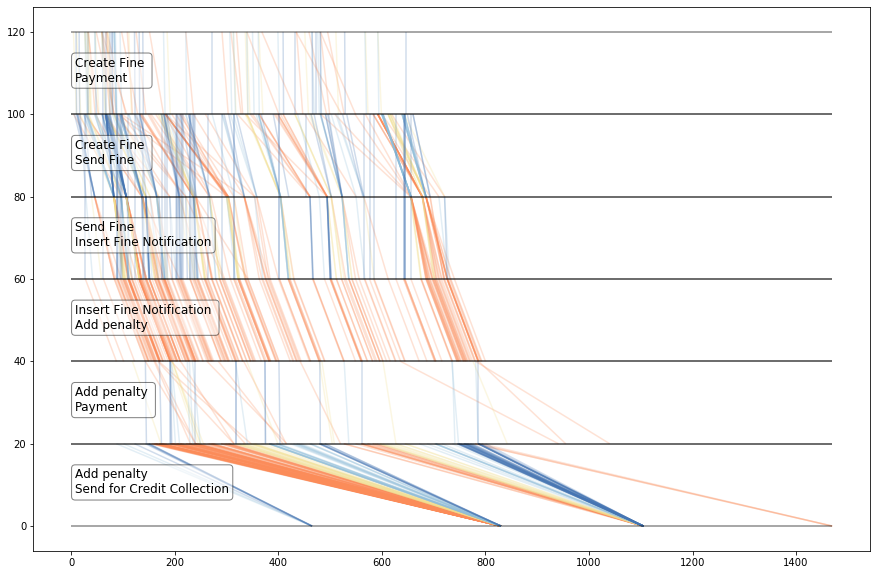

In [15]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=(rf.pf['resource'] == '27'))

### Creation of Performance Spectrum Data Frame using a custom classifier using resource: ###

In [53]:
def classify_resource(df, num_classes=4):
    means = df.groupby('resource').mean()['duration']
    classes = []
    classification = []
    for i in range(0, len(means), len(means)//num_classes):
        classes.append(list(dict(means).keys())[i:i+len(means)//num_classes])
    if sum(len(c) for c in classes) < len(means):
        classes[-1].append(list(dict(means).keys())[-1])
    if len(classes) > num_classes-1:
        classes[-2].extend(classes[-1])
        classes.pop(-1)
    for name, row in df.iterrows():
        is_classified = False
        for i in range(num_classes):
            if row['resource'] in classes[i]:
                classification.append(i)
                is_classified = True
                break
        if not is_classified:
            classification.append(row['resource'])
    return classification


In [ ]:
rf.performance_spectrum(segments, x_max=int(1500), metric=['duration', 'resource'], classifier=classify_resource, args=[4])
rf.pf.head()

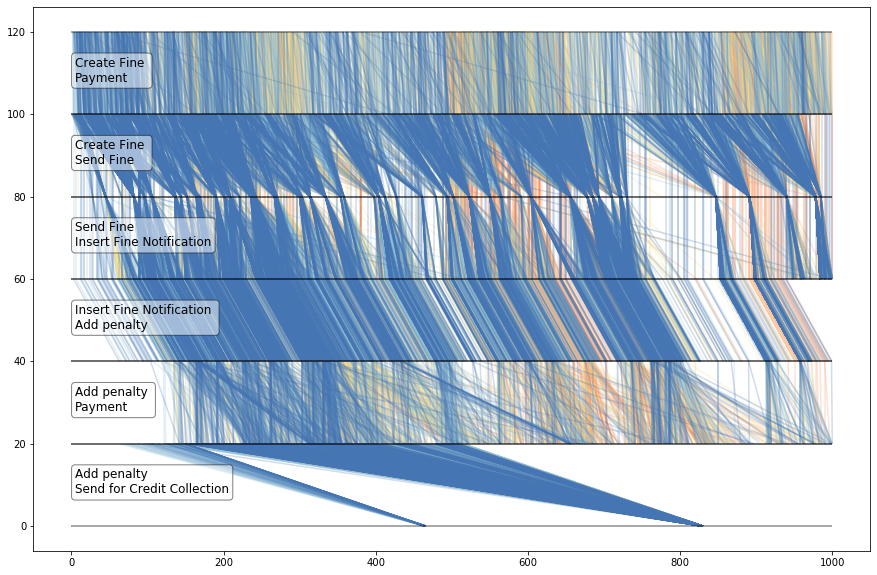

In [52]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=(rf.pf['end_time'] <= 1000))